# Determinantes de la Informalidad Laboral en el Perú: Un enfoque de Aprendizaje Supervisado (EPEN 2024)

## 🎓 Universidad Nacional Mayor de San Marcos
**Facultad de Ciencias Económicas** **Curso:** Econometría III  
**Ciclo:** 9no Ciclo

---

### 👥 Integrantes:
* **Luis Mauricio Aguirre Stornaiuolo**
* **Tilsa Morgana Tejeda Becerra**
* **Gary Magno Alca Chipana**
* **Edwin Joel Quispe Mamani**

---

### 🎯 Finalidad del Proyecto
El presente trabajo de investigación tiene como objetivo principal identificar y analizar los determinantes socioeconómicos de la **informalidad laboral en el Perú** utilizando los microdatos de la **Encuesta Permanente de Empleo Nacional (EPEN) 2024**.

A diferencia de los enfoques tradicionales, este proyecto integra la rigurosidad de la **inferencia econométrica** con la capacidad predictiva del **Machine Learning**, permitiendo una comparación directa entre:
1. **Modelos Logit (Stata/Python):** Para entender la dirección y significancia de los coeficientes (Odds Ratios) y efectos marginales.
2. **Deep Learning (Redes Neuronales):** Para capturar interacciones no lineales y mejorar la precisión en la identificación del trabajador informal.

### 🛠️ Metodología y Herramientas
* **Fuente de Datos:** EPEN 2024 - INEI.
* **Procesamiento:** Limpieza de datos, ingeniería de variables y tratamiento de valores atípicos.
* **Modelado:** Implementación de modelos clasificadores mediante `Scikit-Learn` y redes neuronales densas con `TensorFlow/Keras`.
* **Despliegue:** Creación de un aplicativo interactivo en **Streamlit** para la simulación de probabilidades de informalidad en tiempo real.

---
_Este notebook contiene el flujo completo desde la carga de microdatos hasta la exportación de los modelos finales utilizados en el aplicativo web._

In [ ]:
#LIBRERIAS PARA EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##CARGA DE DATOS

In [ ]:
url = "https://github.com/MrPinkiePie/CLASIFICACION-DE-FAMILIAS-FORMALES-E-INFORMALES/raw/refs/heads/main/EPEN%202024%20BD_Publicacion%20Dpto.zip"

data_original = pd.read_csv(url)

Como necesitamos unicamente al jefe de familia para decidir si el hogar es formal o informal, filtro la pregunta C203 == 1(jefe), ademas filtro la pregunta C303 == 1 para tomar unicamente a los que si trabajan (debemos decidir si estrabajador formal o informal)

In [ ]:
data_filtrada = data_original[(data_original["C303"] == 1) & (data_original["C203"] == 1)].copy()

In [ ]:
data_filtrada["Informal_P"].isna().sum()

np.int64(0)

In [ ]:
data_filtrada.query("C312 == 3")["Informal_P"].value_counts()

,count
Informal_P,
1.0,50033


La pregunta C312 dice lo siguiente:
EL NEGOCIO O EMPRESA DONDE TRABAJA, ¿SE ENCUENTRA
REGISTRADO EN LA SUNAT?, COMO:
1. ¿Persona jurídica (¿Sociedad Anónima SRL, ¿Sociedad Civil, EIRL o
Asociación, etc.?
2. ¿Persona Natural con RUC (RUS, RER, u otro régimen)?
3. ¿NO ESTA REGISTRADO (¿no tiene RUC?
4. NO SABE (solo para dependientes)

En ese sentido, notamos a partir de este filtro que existe una correlación perfecta entre la informalidad y dicha pregunta, es necesario entonces remover la variable C312 del modelo

In [ ]:
cols_epen = [
    # --- 1. PREDICTORES GEOGRÁFICOS (X) ---
    'ESTRATO',        # Tamaño de la población (Densidad de mercado)

    # --- 2. PREDICTORES DEMOGRÁFICOS / SOCIALES (X) ---
    'C207',           # Sexo (Brecha de género)
    'C208',           # Edad (Ciclo de vida - recuerda crear Edad^2)
    'C366',           # Nivel Educativo (Productividad)
    'C376',           # Lengua Materna (Cultural / Exclusión)

    # --- 3. PREDICTORES ECONÓMICOS / PUESTO (X) ---
    'C317',           # Tamaño de empresa (Micro vs Grande)
    'C310',           # Categoría Ocupacional (Independiente vs Empleado)
    'C309_COD',       # Sector Económico (Rubro: Comercio, Servicios, etc.)
    'C318_T'  ,        # Horas trabajadas (Intensidad)
    "Informal_P" #TARGET
]

In [ ]:
data = data_filtrada[cols_epen].copy()

In [ ]:
data["Informal_P"] = data["Informal_P"].astype(int)
data["Informal_P"] = np.where(data["Informal_P"]==1,1,0)

##ANÁLISIS EXPLORATORIO DE DATOS

In [ ]:
sns.set_style("whitegrid")

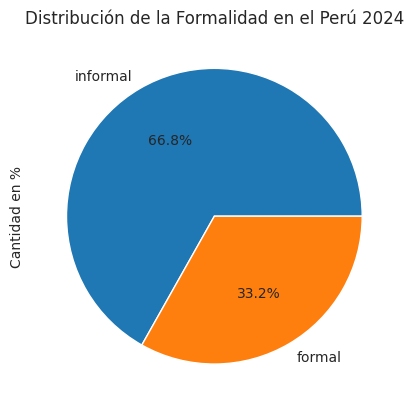

In [ ]:
data["Informal_P"].value_counts().plot(kind="pie",labels = ["informal","formal"],autopct='%1.1f%%')
plt.ylabel("Cantidad en %")
plt.title("Distribución de la Formalidad en el Perú 2024")
plt.show()

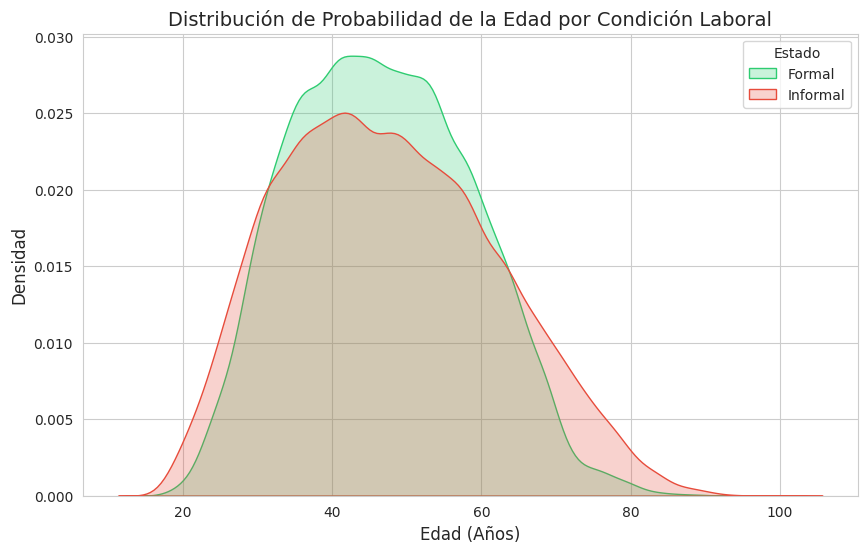

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['Informal_P'] == 0], x='C208', fill=True, label='Formal', color='#2ecc71')
sns.kdeplot(data=data[data['Informal_P'] == 1], x='C208', fill=True, label='Informal', color='#e74c3c')

plt.title('Distribución de Probabilidad de la Edad por Condición Laboral', fontsize=14)
plt.xlabel('Edad (Años)', fontsize=12)
plt.ylabel('Densidad', fontsize=12)
plt.legend(title='Estado')
plt.show()

<Figure size 800x600 with 0 Axes>

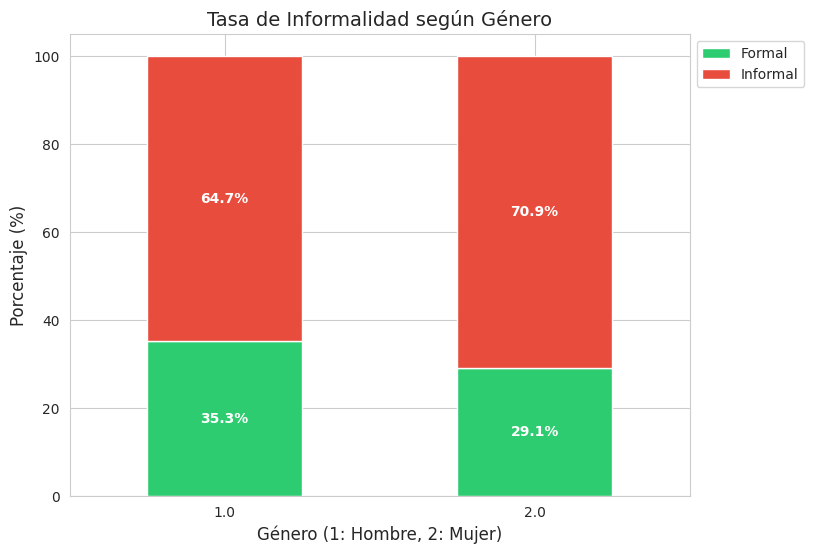

In [ ]:
plt.figure(figsize=(8, 6))
# Suponiendo que C207: 1=Hombre, 2=Mujer
gender_plot = pd.crosstab(data['C207'], data['Informal_P'], normalize='index') * 100

ax = gender_plot.plot(kind='bar', stacked=True, color=['#2ecc71', '#e74c3c'], figsize=(8,6))
plt.title('Tasa de Informalidad según Género', fontsize=14)
plt.xlabel('Género (1: Hombre, 2: Mujer)', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(['Formal', 'Informal'], bbox_to_anchor=(1, 1))

# Añadir etiquetas de porcentaje
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2, y+height/2, f'{height:.1f}%', ha='center', va='center', color='white', fontweight='bold')
plt.show()

/tmp/ipython-input-238/954902409.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='C366', y='Informal_P', order=educ_order, palette='Reds_r', errorbar=None)


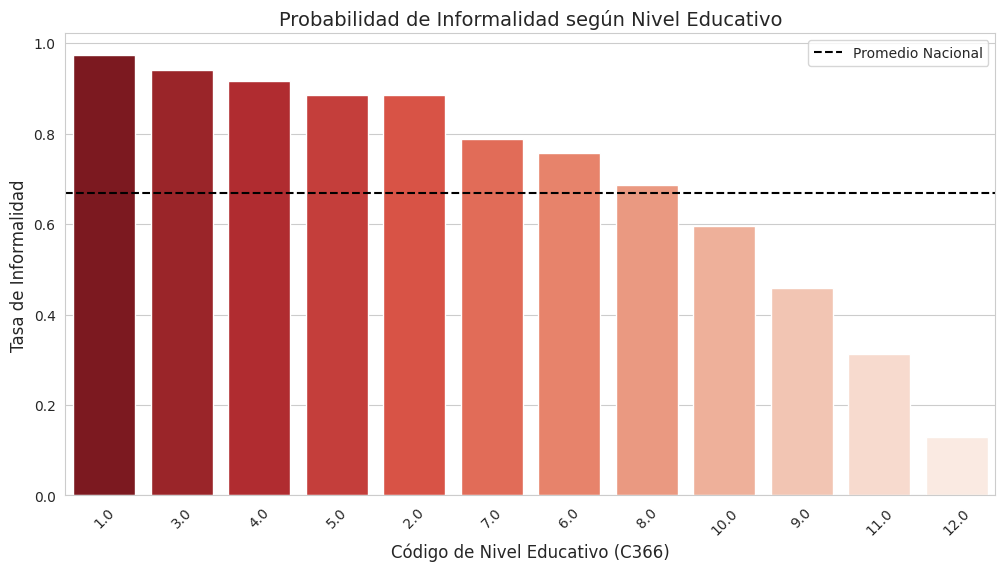

In [ ]:
plt.figure(figsize=(12, 6))
# Agrupamos por nivel educativo y calculamos la media de informalidad
educ_order = data.groupby('C366')['Informal_P'].mean().sort_values(ascending=False).index

sns.barplot(data=data, x='C366', y='Informal_P', order=educ_order, palette='Reds_r', errorbar=None)
plt.axhline(data['Informal_P'].mean(), color='black', linestyle='--', label='Promedio Nacional')

plt.title('Probabilidad de Informalidad según Nivel Educativo', fontsize=14)
plt.xlabel('Código de Nivel Educativo (C366)', fontsize=12)
plt.ylabel('Tasa de Informalidad', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.show()

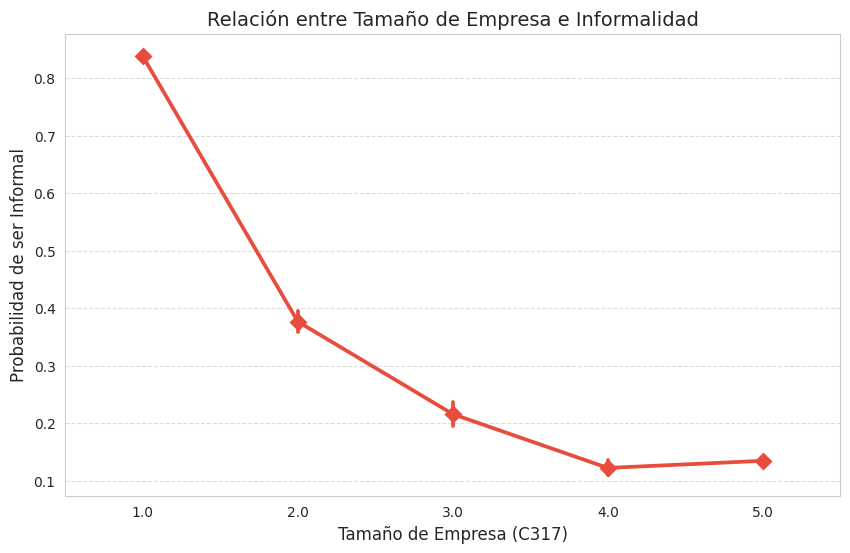

In [ ]:
plt.figure(figsize=(10, 6))
# C317: Generalmente 1=Micro, 2=Pequeña, etc.
sns.pointplot(data=data, x='C317', y='Informal_P', color='#e74c3c', markers="D")

plt.title('Relación entre Tamaño de Empresa e Informalidad', fontsize=14)
plt.xlabel('Tamaño de Empresa (C317)', fontsize=12)
plt.ylabel('Probabilidad de ser Informal', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

##LIMPIEZA DE DATOS

###TRATAMIENTO DE OUTLIERS Y VALORES NULOS

Identificamos que no existen valores nulos en el DataFrame final

In [ ]:
nulos = data.isna().mean().sort_values(ascending = False)
nulos[nulos > 0]

,0


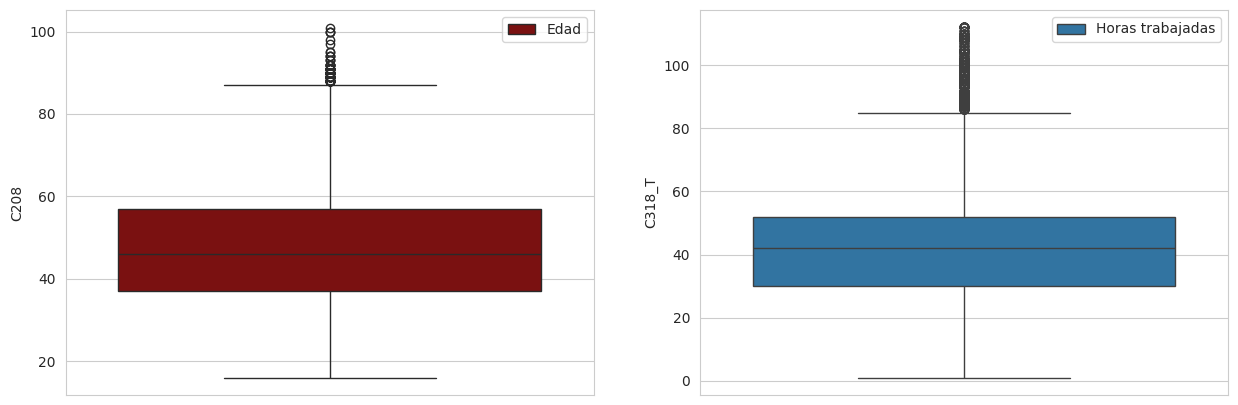

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data = data,y = "C208",label = "Edad",ax = ax[0],color = "darkred")
sns.boxplot(data = data, y = "C318_T",label = "Horas trabajadas",ax = ax[1])
plt.show()

In [ ]:
cols = ["C208","C318_T"]

for col in cols:
  q1,q3 = data[col].quantile([0.25,0.75])
  l_sup = q3 + 1.5*(q3-q1)
  l_inf = q1 - 1.5*(q3-q1)
  nulos = data.query(f"{col} > {l_sup} or {col} < {l_inf}").shape[0]
  print(f"La variable {col} tiene {nulos} valores atípicos, lo que representa un {(nulos/len(data)):.2%}")

La variable C208 tiene 118 valores atípicos, lo que representa un 0.13%
La variable C318_T tiene 1114 valores atípicos, lo que representa un 1.19%


Identificamos valores atípicos en las variables continuas. En consecuencia, procedemos a filtrar los datos. En este caso, no utilizaremos el rango intercuantílico para hacer el filtro, esto debido a que en la realidad peruana, si existen personas de la 3ra edad las cuales se mantienen trabajando. En ese sentido filtraremos por una edad bastante avanzada. Por otro lado, en el caso de la variable de horas trabajadas, filtraremos a aquellas personas cuyas horas semanales trabajadas sea inferior a 112, es decir, 16 horas diarias

In [ ]:
data = data[data["C208"] <= 95]
data = data[data["C318_T"] <= 112]

In [ ]:
data["EDAD"] = data["C208"]
data["EDAD^2"] = data["EDAD"]**2
data.drop(columns=["C208"],inplace=True)

###ESCALADO DE VARIABLES Y OBTENCIÓN DE DUMMIES

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data = data.copy()

In [ ]:
data['C309_COD_NUM'] = pd.to_numeric(data['C309_COD'], errors='coerce').fillna(0)

In [ ]:
def agrupar_sector(codigo):
    if 100 <= codigo <= 399: return '1_Agricultura_Pesca'
    elif 500 <= codigo <= 999: return '2_Mineria'
    elif 1000 <= codigo <= 3399: return '3_Manufactura'
    elif 3500 <= codigo <= 3999: return '4_Electricidad_Agua'
    elif 4100 <= codigo <= 4399: return '5_Construccion'
    elif 4500 <= codigo <= 4799: return '6_Comercio'
    elif codigo >= 4800: return '7_Servicios'
    else: return '8_Otros_No_Especificado'

In [ ]:
def agrupar_educacion(codigo):
    if codigo in [1, 2]:
        return '1_Sin_Nivel_Inicial'
    elif codigo in [3, 4]:
        return '2_Primaria'
    elif codigo in [5, 6, 7]: # Incluye básica especial
        return '3_Secundaria'
    elif codigo in [8, 9]:
        return '4_Superior_Tecnica'
    elif codigo in [10, 11]:
        return '5_Superior_Universitaria'
    elif codigo == 12:
        return '6_Posgrado'
    else:
        return '1_Sin_Nivel_Inicial' # Default por si hay nulos

In [ ]:
def agrupar_idioma(codigo):
    if codigo == 10:
        return '1_Castellano'
    elif 1 <= codigo <= 9:
        return '2_Lengua_Nativa'
    else:
        return '3_Otros'

In [ ]:
def agrupar_categoria_ocupacional(codigo):
    if codigo == 1:
        return '1_Empleador'
    elif codigo == 2:
        return '2_Independiente'
    elif codigo == 3:
        return '3_Asalariado'
    elif codigo in [4, 5, 9, 10]:
        return '4_Trabajador_Familiar'
    elif codigo == 6:
        return '5_Trabajador_Hogar'
    elif codigo in [7, 8]:
        return '6_Practicante'
    else:
        return '3_Asalariado' # Imputación por categoría mayoritaria si hay errores


In [ ]:
def agrupar_estrato(codigo):
        if codigo in [1, 2]: return '1_Metropolitano'
        elif codigo in [3, 4, 5]: return '2_Urbano_Intermedio'
        elif codigo in [6, 7, 8]: return '3_Rural_Semi_Rural'
        else: return '1_Metropolitano'

In [ ]:
data['IDIOMA_MATERNO'] = data['C376'].apply(agrupar_idioma)

In [ ]:
data['NIVEL_EDUCATIVO'] = data['C366'].apply(agrupar_educacion)

In [ ]:
data['MACRO_SECTOR'] = data['C309_COD_NUM'].apply(agrupar_sector)

In [ ]:
data['CATEGORIA_OCUPACIONAL'] = data['C310'].apply(agrupar_categoria_ocupacional)

In [ ]:
data["URBANO"] = data["ESTRATO"].apply(agrupar_estrato)

In [ ]:
data = data.drop(columns=['C309_COD', 'C309_COD_NUM','C366', 'C376','C310',"ESTRATO"])

In [ ]:
vars_continuas = ["EDAD","EDAD^2","C318_T"]

In [ ]:
scaler = StandardScaler()

data[vars_continuas] = scaler.fit_transform(data[vars_continuas])

In [ ]:
vars_categoricas = [
    'C207','NIVEL_EDUCATIVO','IDIOMA_MATERNO',
    'C317', 'MACRO_SECTOR','CATEGORIA_OCUPACIONAL',"URBANO"
]

In [ ]:
data_final = pd.get_dummies(data, columns=vars_categoricas, drop_first=True, dtype=int)

Durante el análisis descubrimos que la variable EDAD^2 tiene una correlación casi perfecta con la variable target, de modo que, optamos por removerla del modelo

In [ ]:
data_final = data_final.drop("EDAD^2",axis = 1)

##MODELO DE REGRESIÓN LOGÍSTICA

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc,roc_curve,classification_report,confusion_matrix

In [ ]:
X = data_final.drop(columns=["Informal_P"])
y = data_final["Informal_P"]

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
modelo_logit = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
modelo_logit.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
y_pred = modelo_logit.predict(X_test)

###ANÁLISIS DE MÉTRICAS

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      6155
           1       0.90      0.87      0.88     12531

    accuracy                           0.84     18686
   macro avg       0.82      0.83      0.83     18686
weighted avg       0.85      0.84      0.85     18686



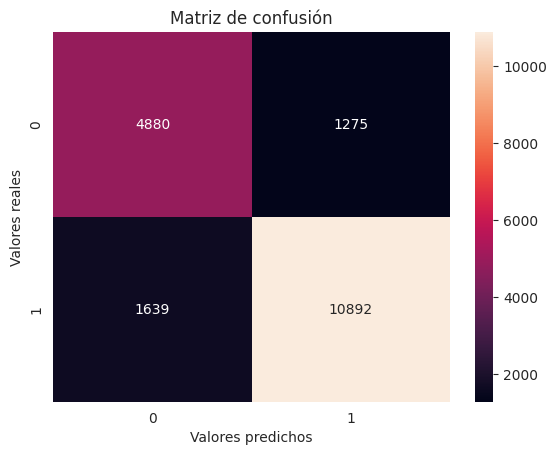

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt="d")

plt.title("Matriz de confusión")
plt.ylabel("Valores reales")
plt.xlabel("Valores predichos")
plt.show()

###ANÁLISIS DE LA CURVA ROC

In [ ]:
y_prob = modelo_logit.predict_proba(X_test)[:,1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test,y_prob)
roc_auc = auc(fpr, tpr)

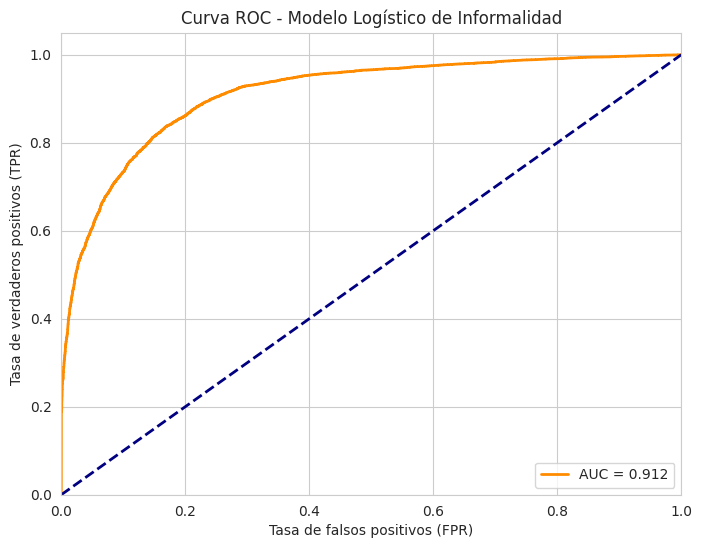

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Modelo Logístico de Informalidad")
plt.legend(loc="lower right")
plt.show()

###ODDs Ratios

In [ ]:
variables = X_train.columns
betas = modelo_logit.coef_[0]

In [ ]:
odds_ratios = np.exp(betas)

In [ ]:
df_resultados = pd.DataFrame({'Variable': variables, 'Coeficiente': betas, 'Odds Ratio': odds_ratios})

In [ ]:
df_resultados.sort_values(by='Odds Ratio', ascending=False)

,Variable,Coeficiente,Odds Ratio
22,CATEGORIA_OCUPACIONAL_4_Trabajador_Familiar,6.493703,660.966367
24,CATEGORIA_OCUPACIONAL_6_Practicante,5.457628,234.540429
23,CATEGORIA_OCUPACIONAL_5_Trabajador_Hogar,3.072695,21.600039
20,CATEGORIA_OCUPACIONAL_2_Independiente,1.815833,6.146196
21,CATEGORIA_OCUPACIONAL_3_Asalariado,1.663164,5.275976
26,URBANO_3_Rural_Semi_Rural,0.666738,1.947873
2,C207_2.0,0.353525,1.424078
8,IDIOMA_MATERNO_2_Lengua_Nativa,0.246220,1.279181
25,URBANO_2_Urbano_Intermedio,-0.062856,0.939079
1,EDAD,-0.284718,0.752226


##Modelo Logístico con StatsModels

In [ ]:
import statsmodels.api as sm

In [ ]:
X_train_sm = sm.add_constant(X_train)


modelo_econometrico = sm.Logit(y_train, X_train_sm).fit(method='bfgs', maxiter=100)

print(modelo_econometrico.summary())

/usr/local/lib/python3.12/dist-packages/scipy/optimize/_optimize.py:1330: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.348568
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101
                           Logit Regression Results                           
Dep. Variable:             Informal_P   No. Observations:                74743
Model:                          Logit   Df Residuals:                    74715
Method:                           MLE   Df Model:                           27
Date:                Fri, 27 Feb 2026   Pseudo R-squ.:                  0.4517
Time:                        01:13:35   Log-Likelihood:                -26053.
converged:                      False   LL-Null:                       -47516.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const  

In [ ]:
params = modelo_econometrico.params

odds_ratios = np.exp(params)
print(odds_ratios.sort_values(ascending=False))

CATEGORIA_OCUPACIONAL_4_Trabajador_Familiar    432.182264
CATEGORIA_OCUPACIONAL_5_Trabajador_Hogar        54.618675
CATEGORIA_OCUPACIONAL_6_Practicante             20.263078
const                                            9.453408
CATEGORIA_OCUPACIONAL_2_Independiente            6.287236
CATEGORIA_OCUPACIONAL_3_Asalariado               5.385952
URBANO_3_Rural_Semi_Rural                        1.655983
C207_2.0                                         1.372104
IDIOMA_MATERNO_2_Lengua_Nativa                   1.359859
NIVEL_EDUCATIVO_2_Primaria                       1.192114
URBANO_2_Urbano_Intermedio                       0.953999
C318_T                                           0.745660
EDAD                                             0.741346
IDIOMA_MATERNO_3_Otros                           0.584555
NIVEL_EDUCATIVO_3_Secundaria                     0.577711
MACRO_SECTOR_5_Construccion                      0.418945
MACRO_SECTOR_4_Electricidad_Agua                 0.267006
NIVEL_EDUCATIV

##MODELO DE REDES NEURONALES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
model_dl = models.Sequential([
    # Capa de entrada
    layers.Input(shape=(X_train.shape[1],)),

    # Capa oculta 1
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    # Capa oculta 2
    layers.Dense(16, activation='relu'),

    # Capa de salida: 1 'sigmoid' porque es clasificación binaria
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_dl.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Función de pérdida para Logit/Binaria
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

In [ ]:
history = model_dl.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7776 - loss: 0.4599 - recall: 0.9154 - val_accuracy: 0.8522 - val_loss: 0.3417 - val_recall: 0.9274
Epoch 2/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8538 - loss: 0.3478 - recall: 0.9190 - val_accuracy: 0.8578 - val_loss: 0.3347 - val_recall: 0.9213
Epoch 3/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8581 - loss: 0.3358 - recall: 0.9134 - val_accuracy: 0.8589 - val_loss: 0.3280 - val_recall: 0.9087
Epoch 4/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8579 - loss: 0.3318 - recall: 0.9122 - val_accuracy: 0.8581 - val_loss: 0.3252 - val_recall: 0.9189
Epoch 5/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8611 - loss: 0.3280 - recall: 0.9143 - val_accuracy: 0.8601 - val_loss: 0.3233 - val_recall: 0.9104
Epoch 6/20
1052/1052 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8575 - loss: 0.3271 - recall: 0.9103 - val_accuracy: 0.8597 - val_loss: 0.3210 - val_recall

In [ ]:
loss, acc, recall = model_dl.evaluate(X_test, y_test)
print(f"\nAccuracy en Deep Learning: {acc:.4f}")
print(f"Recall en Deep Learning: {recall:.4f}")

584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8634 - loss: 0.3152 - recall: 0.9163

Accuracy en Deep Learning: 0.8628
Recall en Deep Learning: 0.9190


In [ ]:
y_prob_dl = model_dl.predict(X_test)
y_pred_dl = (y_prob_dl > 0.5).astype("int32")

584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
print(classification_report(y_test, y_pred_dl, target_names=['Formal (0)', 'Informal (1)']))

              precision    recall  f1-score   support

  Formal (0)       0.82      0.75      0.78      6155
Informal (1)       0.88      0.92      0.90     12531

    accuracy                           0.86     18686
   macro avg       0.85      0.83      0.84     18686
weighted avg       0.86      0.86      0.86     18686



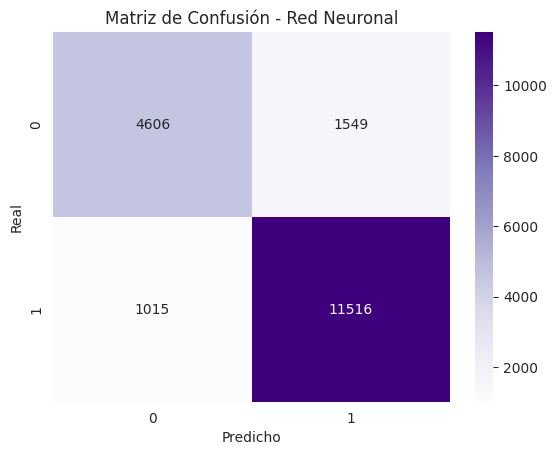

In [ ]:
cm = confusion_matrix(y_test, y_pred_dl)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Matriz de Confusión - Red Neuronal')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

##Exportación de los Modelos y Scaler y graficos

---

import joblib
import os


# Crear carpeta
if not os.path.exists('models'):
    os.makedirs('models')

# Guardar modelos
model_dl.save('models/model_dl.keras')
print("¡Modelo guardado con éxito en la carpeta models!")

---